# Initial Exploratory Data Analysis for the HR Separation (hrsepara) project
## Identify the correct working directory for source data
* '/data/discovery/hrsepara/core/'
## Identify the correct working directory for the analysis (both HDFS and LFS)
* '/data/discovery/hrsepara/staging/eda' and  '/home/kesj/working/hrsepara/eda/'
## begin to summarize data 


In [1]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'


In [49]:
import os,subprocess
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
# check if the path exists
os.path.exists(stgdir1local)

True

In [4]:
def hdfs_path_exists(path):
    return subprocess.call(['hdfs','dfs','-ls',path])
    

In [5]:
hdfs_path_exists(coredir)

0

In [7]:
# make the remote directory
if not hdfs_path_exists(stgdir1):
    !hdfs dfs -mkdir {stgdir1}

mkdir: `/data/discovery/hrsepara/staging/eda': File exists


In [8]:
# check if the path exists
if not os.path.exists(stgdir1local):
    # make the local directory
    !mkdir {stgdir1local}
    #'/home/kesj/work/hrsepara/eda'


%pwd

u'/home/kesj/ipynb/HRsepara'

In [9]:
%cd {stgdir1local}

/home/kesj/work/hrsepara/eda


In [13]:
#define the currentworking directory:
cwd = os.path.abspath(os.curdir)
print cwd

/home/kesj/work/hrsepara/eda


## Look at the files in {coredir}

In [10]:
fnames = !hdfs dfs -ls {coredir}

In [11]:
infilenames = [f.split()[-1] for f in fnames[1:]]

In [12]:
infilenames

['/data/discovery/hrsepara/core/EMPL',
 '/data/discovery/hrsepara/core/HISTCURR',
 '/data/discovery/hrsepara/core/HISTRET',
 '/data/discovery/hrsepara/core/HISTRETold',
 '/data/discovery/hrsepara/core/SBR',
 '/data/discovery/hrsepara/core/SR_BENEFIT.txt',
 '/data/discovery/hrsepara/core/SR_CKE.txt',
 '/data/discovery/hrsepara/core/SR_COMP.txt',
 '/data/discovery/hrsepara/core/SR_CPR.txt',
 '/data/discovery/hrsepara/core/SR_EAS.txt',
 '/data/discovery/hrsepara/core/SR_EDU.txt',
 '/data/discovery/hrsepara/core/SR_INS.txt',
 '/data/discovery/hrsepara/core/SR_LANG.txt',
 '/data/discovery/hrsepara/core/SR_LIC.txt',
 '/data/discovery/hrsepara/core/SR_RELO.txt']

# Now I need to get this data into a format so that I can read it from pandas

In [14]:
## function to load into pandas from hdfs (by copying to local filespace)
def pandas_read_hdfs(infile,sep = ';',dtype_dict = None):
    # copy the infile to the cwd
    !hdfs dfs -get {infile} .
    # identify the local file name
    inname = infile[infile.rfind('/')+1:]
    # read into a data frame
    if dtype_dict != None:
        df = pd.read_csv(inname,sep=sep,dtype =dtype_dict)
    else:
        df = pd.read_csv(inname,sep=sep)
    # clean up local filespace
    !rm {inname}
    return df

## Load the base empl table

In [15]:
empl_df = pandas_read_hdfs(infilenames[0],dtype_dict={'KEY':np.str})
empl_df.shape

(334162, 20)

## Define types for specific columns

In [30]:
hist_record_dtype_dict = {'KEY':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SKEY':np.str,'JOBCODE':np.str,'EMPL_CLASS':np.str, 
                          'SHIFT':np.str,'COMPANY':np.str,'EXT_FUNC_ID_SFI':np.str,'FUNC_ID_SFI':np.str,
                          'DIVISION_CODE_SFI':np.str,'JOB_FAMILY':np.str,'JOB_FUNCTION':np.str}
#,'COUNT':np.float,'FUNC_CNT':np.float}
#dictionary to load the histcurr and histret columns the same way

## rename the last 2 columns of HISTCURR to match HISTRET

In [31]:
histcurr_df = pandas_read_hdfs(infilenames[1],dtype_dict=hist_record_dtype_dict)
print histcurr_df.shape#, histcurr_df.columns
# rename the last two columns to match histret
histcurr_df.rename(columns = {'COUNT':'FUNC_CNT','COUNT.1':'EXTFUNC_CNT'},inplace=True)

(70609, 159)


## 04.01.2015 

* load the updated HISTRET file from HDFS

In [32]:
histret_df = pandas_read_hdfs(infilenames[2],dtype_dict=hist_record_dtype_dict)
histret_df.shape#,histret_df.columns

/opt/anaconda/2.1.0/lib/python2.7/site-packages/pandas/io/parsers.py:1164: DtypeWarning: Columns (96,97,98,99,100,101,102,103,104,106,107,108,109,110,111,112,113,114,116,117,118,119,120,121,122,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


(172554, 160)

In [33]:
histret_df.columns[95:105]

Index([u'ACTRES1', u'ACTRES2', u'ACTRES3', u'ACTRES4', u'ACTRES5', u'ACTRES6', u'ACTRES7', u'ACTRES8', u'ACTRES9', u'ACTRES10'], dtype='object')

In [28]:
histret_df['JOB_FUNCTION'].unique()

array([nan, 'NSA', 'PTB', 'PSA', 'MGT', 'PTA', 'PSB', 'PTC', 'PSC', 'PTI',
       'PTF', 'PTE', 'PTH', 'PTG', 'PTD', 'PTJ', 'PTM', 'PTL', 'H08', 'PTK'], dtype=object)

In [35]:
histret_df.VOLINVOL.value_counts()

VOLUNTARY      110899
INVOLUNTARY     60663
UNKNOWN           501
OTHER             491
dtype: int64

#### add a column to histcurr_df corresponding to the new  VOLINVOL column:
* value is 'NOT'

In [36]:
histcurr_df['VOLINVOL'] = 'NOT'

## load the 'modified HISTRET file' from local filespace -- corrects the overfilled files

In [ ]:
##histret_df = pandas_read_hdfs(infilenames[2],dtype_dict=hist_record_dtype_dict)
##histret_df.shape#,histret_df.columns
#histret_df = pd.read_csv('histret_mod',sep=';',dtype=hist_record_dtype_dict)
#histret_df.shape

## Try to join EMPL, HISTCURR & HISTRET

In [37]:
ncurr = len(histcurr_df)
nret = len(histret_df)
print "number of current, retired, total, total_of_interest:",ncurr,nret,len(empl_df),ncurr + nret

number of current, retired, total, total_of_interest: 70609 172554 334162 243163


### some helper functions

In [96]:
# function to truncate POSTAL_ZIP to zip5
def truncate_postal_zip(in_zip):
    try:
        out_zip = in_zip[:5]
        #print out_zip
    except:
        #out_zip = str(in_zip)[:5]
        out_zip = np.nan
    return out_zip

In [39]:
def summarize_dataframe(df,show_example=False):
    nrow = len(df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        if show_example:
            print col, df[col].dtype,nmiss, "\t", len(df[col].unique()),":\t", df[col].ix[8320]
        else:
            print col, df[col].dtype,nmiss, "\t", len(df[col].unique())

In [40]:
def summarize_dataframe2(df,show_example=False):
    nrow = len(df)
    summary_df = pd.DataFrame(columns = ['Column','datatype','nmissing','arity','accepted values'])
    len_df = len(summary_df)
    for col in df.columns:
        nmiss = nrow - df[col].value_counts().sum()
        narity = len(df[col].unique())
        if show_example:
            print col, df[col].dtype,nmiss, "\t", narity,":\t", df[col].ix[8320]
        else:
            print col, df[col].dtype,nmiss, "\t", narity
        accept_val = None
        if narity < 20:
            accept_val = df[col].unique()
        summary_df.loc[len_df] = [col,df[col].dtype,nmiss,narity,accept_val]
        len_df+=1
    return summary_df

### merge the files 
* cur_empl
* ret_empl

In [41]:
ret_empl = pd.merge(histret_df,empl_df,left_on='KEY',right_on='KEY',how='inner')
cur_empl = pd.merge(histcurr_df,empl_df,left_on='KEY',right_on='KEY',how='inner')
print len(ret_empl),len(cur_empl)

172554 70609


In [42]:
column_list = histret_df.columns
len(column_list)

160

## CLEAN UP THE DATA

### Remove the cases of ON(tario)

In [44]:
sum(cur_empl.LOC_STATE=='ON'), sum(ret_empl.LOC_STATE == 'ON')

(0, 7)

In [46]:
ret_empl = ret_empl[ret_empl.LOC_STATE != 'ON']

## why are there missing termination dates from histret_df?


In [50]:
sum(histret_df.TERMINATION_DT.isnull())

73

In [ ]:
histret_df[histret_df.TERMINATION_DT.isnull()]

### convert the date columns
* import datetime library
* identify the correct columns
* replace nan TERMINATION DATE with Jan, 1, 2015 for cur_empl
* calculate tenure
* calculate age at TERM DATE


In [51]:
from datetime import datetime

In [52]:
# create list of date columns
date_columns = ['TERMINATION_DT','HIRE_DT','SERVICE_DT','LAST_HIRE_DT','BIRTHDATE']

In [53]:
##count how many of these are missing
print "Column\t     Current\t Retired"
print "++++++++++++++++++++++++++++++++++++"
for c in date_columns:
    print c, "\t",sum(cur_empl[c].isnull()), "\t",sum(ret_empl[c].isnull())

Column	     Current	 Retired
++++++++++++++++++++++++++++++++++++
TERMINATION_DT 	70609 	73
HIRE_DT 	0 	2
SERVICE_DT 	0 	0
LAST_HIRE_DT 	0 	1
BIRTHDATE 	0 	0


* replace the missing TERMINATION_DT with '01JAN2015'
* replace the missing HIRE_DT & LAST_HIRE_DT with SERVICE_DT for the Retired employees

In [54]:
termination_replace_dt = '01JAN2015'
ret_empl['TERMINATION_DT'].fillna(termination_replace_dt,inplace=True)
cur_empl['TERMINATION_DT'].fillna(termination_replace_dt,inplace=True)
#sum(ret_empl['TERMINATION_DT'].isnull())

In [55]:
#ret_empl[ret_empl['HIRE_DT'].isnull()].HIRE_DT = 
#ret_empl[
missing_idx =ret_empl[ret_empl['HIRE_DT'].isnull()].index
ret_empl.loc[missing_idx,'HIRE_DT'] = ret_empl.loc[missing_idx,'SERVICE_DT']
missing_idx =ret_empl[ret_empl['LAST_HIRE_DT'].isnull()].index
ret_empl.loc[missing_idx,'LAST_HIRE_DT'] = ret_empl.loc[missing_idx,'SERVICE_DT']

In [56]:
#now convert to datetimes
for c in date_columns:
    ret_empl[c]=ret_empl[c].apply(lambda x:datetime.strptime(x,'%d%b%Y')) 
    cur_empl[c]=cur_empl[c].apply(lambda x:datetime.strptime(x,'%d%b%Y')) 
#ret_empl[date_columns].apply(lambda x: datetime.strptime(x,'%d%b%Y'),axis=0)

In [57]:
## now calculate age at termination date
cur_empl['Age_tdelta'] = cur_empl['TERMINATION_DT']-cur_empl['BIRTHDATE']#)/np.timedelta64(1,'D')
ret_empl['Age_tdelta'] = ret_empl['TERMINATION_DT']-ret_empl['BIRTHDATE']#)/np.timedelta64(1,'D')## calculate tenure at termination date (use service_date)
# Use HIRE_DATE (SERVICE DATE Can be later than termination date if they have been rehired)
cur_empl['Tenure_tdelta'] = cur_empl['TERMINATION_DT']-cur_empl['HIRE_DT']
ret_empl['Tenure_tdelta'] = ret_empl['TERMINATION_DT']-ret_empl['HIRE_DT']
# convert to days, months or years
cur_empl['Age_years'] = cur_empl['Age_tdelta']/np.timedelta64(1,'Y')
ret_empl['Age_years'] = ret_empl['Age_tdelta']/np.timedelta64(1,'Y')
# convert to months of tenure
cur_empl['Tenure_months'] = cur_empl['Tenure_tdelta']/np.timedelta64(1,'M')
ret_empl['Tenure_months'] = ret_empl['Tenure_tdelta']/np.timedelta64(1,'M')
#cur_empl['Tenure_months'] = cur_empl['Tenure_tdelta']/np.timedelta64(1,'D')



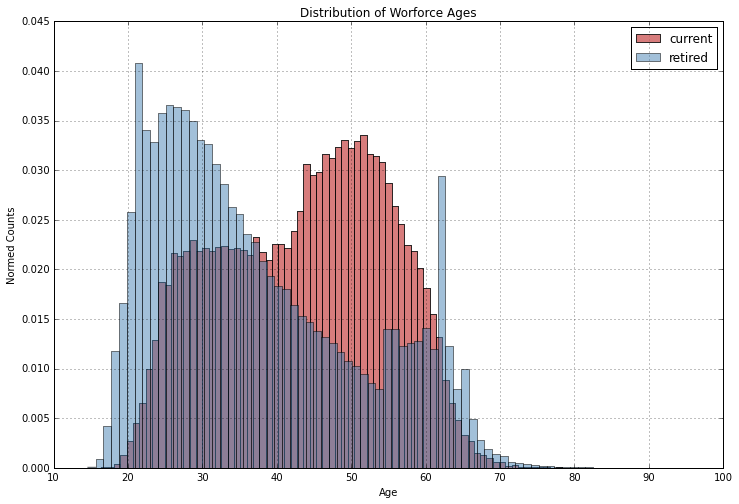

In [58]:
# look at these distributions
plt.figure(figsize=(12,8))
cur_empl.Age_years.hist(bins=80,color='indianred',label='current',alpha=0.8,normed=True)
ret_empl.Age_years.hist(bins=80,color='steelblue',label='retired',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Ages')

In [59]:
ret_empl.Age_years.describe(), cur_empl.Age_years.describe()

(count    172547.000000
 mean         37.290639
 std          13.720188
 min          14.609472
 25%          26.103205
 50%          33.687208
 75%          46.853803
 max          98.197773
 Name: Age_years, dtype: float64, count    70609.000000
 mean        43.646929
 std         11.307643
 min         16.424704
 25%         34.193721
 50%         44.830489
 75%         52.652690
 max         84.311108
 Name: Age_years, dtype: float64)

In [60]:
ret_empl.Tenure_months.describe(), cur_empl.Tenure_months.describe()

(count    172547.000000
 mean         90.312257
 std         126.589908
 min          -0.032855
 25%           6.340993
 50%          29.799380
 75%         120.511715
 max         781.519128
 Name: Tenure_months, dtype: float64, count    70609.000000
 mean       176.848788
 std        135.307106
 min          0.098565
 25%         35.516130
 50%        176.562147
 75%        285.278959
 max        738.972053
 Name: Tenure_months, dtype: float64)

In [61]:
sum(ret_empl.Tenure_months < 0), sum(ret_empl.TOT_MO_SERVICE_SFI < 0)

(146, 289)

In [62]:
neg_tenure_idx = ret_empl[ret_empl.Tenure_months < 0].index
ret_empl.ix[neg_tenure_idx][['TOT_MO_SERVICE_SFI','Tenure_months','TERMINATION_DT','HIRE_DT','LAST_HIRE_DT']].tail()

,TOT_MO_SERVICE_SFI,Tenure_months,TERMINATION_DT,HIRE_DT,LAST_HIRE_DT
158084,-1,-0.032855,2001-09-09,2001-09-10,2001-09-10
158085,-1,-0.032855,2001-09-09,2001-09-10,2001-09-10
158088,-1,-0.032855,2001-10-14,2001-10-15,2001-10-15
161230,-1,-0.032855,2006-11-12,2006-11-13,2006-11-13
165174,-1,-0.032855,2007-02-22,2007-02-23,2007-02-23


In [433]:
ret_empl.ix[neg_tenure_idx]['KEY'].tail().values

array(['849342842050522', '677436375840305', '123550771793141',
       '851255668723609', '874169302580026'], dtype=object)

In [ ]:
# how many are younger than 16?
sum(ret_empl.Age_years < 16.01), sum(cur_empl.Age_years < 16.01)

In [63]:
#
time_checking_cols = [a for a in date_columns]
time_checking_cols.append('Tenure_months')
time_checking_cols.append('Age_years')
time_checking_cols.append('CUR_LOC_MOS')

In [ ]:
ret_empl[ret_empl.Age_years<16.01][time_checking_cols]

In [64]:
sum(ret_empl.Tenure_months < 0), sum(cur_empl.Tenure_months < 0)

(146, 0)

# Cleaning up these dates
### remove the negative tenure cases

In [65]:
ret_empl2 = ret_empl[ret_empl.Tenure_months>=0].copy()
len(ret_empl2)

172401

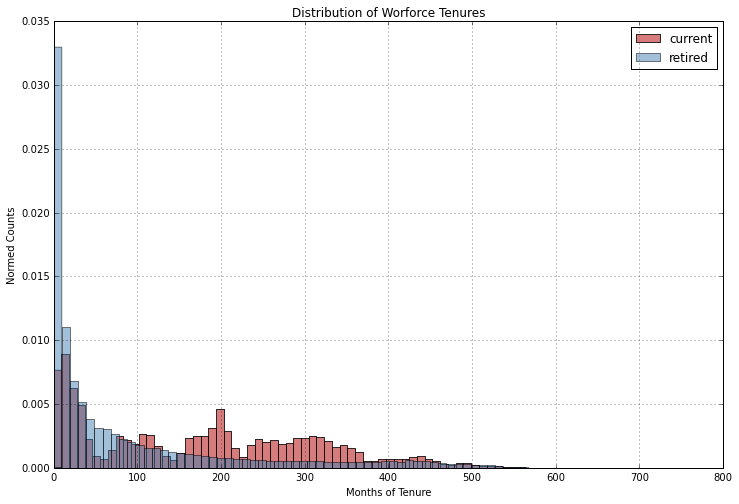

In [66]:
# look at these distributions
plt.figure(figsize=(12,8))
cur_empl.Tenure_months.hist(bins=80,color='indianred',label='current',alpha=0.8,normed=True)
ret_empl2.Tenure_months.hist(bins=80,color='steelblue',label='retired',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Months of Tenure')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Tenures')

## Begin Survival Analysis
* create a new column 'status' = 1 if retired; 0 otherwise
* join the two *_empl data frame

In [67]:
ret_empl2['status'] = 1
cur_empl['status'] = 0
# now join
print len(ret_empl2),len(cur_empl)
empltbl = pd.concat([ret_empl2,cur_empl],axis=0)
print len(empltbl)

172401 70609
243010


## look for duplicated KEYS (and remove)

In [68]:
duplicated_keys_list = list(empltbl.KEY.value_counts()[empltbl.KEY.value_counts() >1].index)
duplicated_keys_list

[]

In [69]:
empltbl.KEY.nunique()

243010

In [ ]:
# duplicated employee keys:
dup_empl_keys = []
for a in empltbl.KEY.value_counts().index[:4]:
    print a
    dup_empl_keys.append(a)

for empkey in dup_empl_keys:
    print empltbl[empltbl.KEY == empkey]

## Keep the first instance for these 4 duplicated employee keys.
* the first 2 cases have longer tenure but same address, sex, birthdate and hire_dt
* the third case have same address,sex, birthdate, hire_dt and termination_dt; the first instance is Fulltime versus Partime 

In [ ]:
empltbl.drop_duplicates(subset='KEY',inplace=True)
len(empltbl)

In [ ]:
# look at these distributions
plt.figure(figsize=(12,8))
cur_empl.Age_years.hist(bins=80,color='indianred',label='current',alpha=0.8,normed=True)
ret_empl2.Age_years.hist(bins=80,color='steelblue',label='retired',alpha=0.5,normed=True)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Normed Counts')
plt.title('Distribution of Worforce Ages')

## Continue to Refine the input data

In [100]:
sum(empltbl.zip5.isnull())

171

In [97]:
# add column for zip5
empltbl['zip5'] = empltbl['POSTAL_SFI'].apply(lambda x: truncate_postal_zip(x))

In [98]:
empltbl[empltbl.zip5=='SW18 '].values

array([[ 'COMPANY WIDE CONVERSION;REGIONAL CONVERSION;TRANSFER W/ JOB NUMBER CHANGE;MERIT;PROMOTION WITH MERIT INCREASE;COST OF LIVING ADJUSTMENT;ANOTHER OPPORTUNITY',
        nan,
        'EMPLOYEE NEW HIRE;TRANSFER W/O JOB NUMBER CHANGE;COST OF LIVING ADJUSTMENT;MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA CHANGE',
        nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0,
        '18 BRATHWAY ROAD', nan, 33011.58,
        Timedelta('12935 days 00:00:00'), 35.414827135396344,
        Timestamp('1965-04-17 00:00:00'), 'S', nan, nan, nan, nan, nan,
        nan, nan, nan, nan, '005', 'A', 5.93548387, 5.93548387,
        15.064516099999999, 3.19354839, 3.19354839, 5.93548387, 1, 2, 2, 2,
        9.0, '1', '2', 1, 1, 1, 1, '1', 'S', 1.0, 1542.0, '00063', 0, 0, 0,
        0, 999, 'Z', 1.0, 0, 0, 0, 0, 'N', 'N', 'N', 'N', 'F', 0, 0, 0, 0,
        36256.0, '00014', 'MA1', 1, 1, 1, 1,
        Timestamp('1999-06-14 00:00:00'), 'N', 'N', 2, 2, 2, 2, '0153',
        nan, nan, '72282220689711

In [104]:
empltbl[empltbl['STATE'].isnull()][['POSTAL_SFI','LOC_STATE','ADDRESS1']]

,POSTAL_SFI,LOC_STATE,ADDRESS1
124,NaN,NaN,NaN
541,NaN,NaN,NaN
834,NaN,NaN,NaN
835,NaN,NaN,NaN
909,NaN,NaN,NaN
1435,NaN,NaN,NaN
1953,NaN,NaN,NaN
2195,NaN,AZ,NaN
2521,NaN,NaN,NaN
2890,NaN,NC,C/O ELBOW CAY BEACH INN


In [105]:
sdf = summarize_dataframe2(empltbl)

ACTRES1 object 71 	27931
ACTRES10 object 162653 	12402
ACTRES2 object 55228 	24122
ACTRES3 object 94462 	20617
ACTRES4 object 114253 	18666
ACTRES5 object 126127 	15019
ACTRES6 object 134126 	12415
ACTRES7 object 141312 	13382
ACTRES8 object 149309 	11453
ACTRES9 object 155885 	11772
ADDRCNT1 float64 125 	6
ADDRCNT10 float64 125 	15
ADDRCNT3 float64 125 	10
ADDRCNT5 float64 125 	12
ADDRESS1 object 127 	231398
ADDRESS2 object 226967 	8807
ANNUAL_RT float64 0 	132927
Age_tdelta timedelta64[ns] 0 	19737
Age_years float64 0 	19737
BIRTHDATE datetime64[ns] 0 	24857
BOX1 object 111794 	4
BOX10 object 170699 	4
BOX2 object 102708 	4
BOX3 object 119528 	4
BOX4 object 130752 	4
BOX5 object 138540 	4
BOX6 object 145113 	4
BOX7 object 152804 	4
BOX8 object 158869 	4
BOX9 object 165079 	4
COMPANY object 0 	7
COMP_FREQUENCY object 0 	4
CUR_DEPT_MOS float64 0 	5388
CUR_EFUNC_MOS float64 0 	7917
CUR_FUNC_MOS float64 0 	9048
CUR_GRADE_MOS float64 0 	4876
CUR_JOB_MOS float64 0 	6476
CUR_LOC_MOS float64

In [72]:
sdf.to_csv('employee_table_summary.csv')
# save to file

In [73]:
empltbl.status.value_counts()

1    172401
0     70609
dtype: int64

### restrict the dataframe to do linear-regression on.
* first attempt is _ad hoc_ reduction of 185 columns
    * keep age_years, tenure_months, status, sex for sure
* look at cases where there is 'significant' correlation between columns:
    * for example JOBCNTx, LOCCNTx, DEPTCNTx, ...

In [106]:
# define the set of columns that have missing values smaller than some threshold 
sdf['x_missing'] = sdf['nmissing']/len(empltbl)
len(sdf[sdf['x_missing'] > 0]), len(sdf)

(83, 185)

In [107]:
# now apply some logic to these columns for keeping and not
columns_to_fix_missing = []
columns_to_fix_NY = []
columns_to_omit = []

In [76]:
#
missing_threshold = 0.40
print len(sdf[(sdf['x_missing']>0) & (sdf['x_missing'] <= missing_threshold)])
columns_to_fix_missing = sdf[(sdf['x_missing']>0) & (sdf['x_missing'] <= missing_threshold)].Column


53


In [77]:
sdf.ix[columns_to_fix_missing.index].datatype.value_counts()

float64    37
object     16
dtype: int64

In [79]:
columns_to_fix_missing.head()

0       ACTRES1
2       ACTRES2
3       ACTRES3
10     ADDRCNT1
11    ADDRCNT10
Name: Column, dtype: object

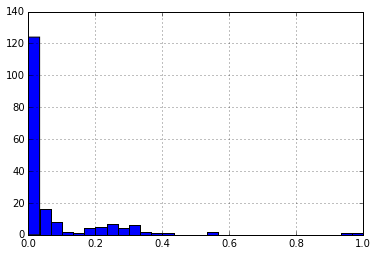

In [111]:
sdf['y_arity'] = sdf['arity']/len(empltbl)
sdf['y_arity'].hist(bins=30)

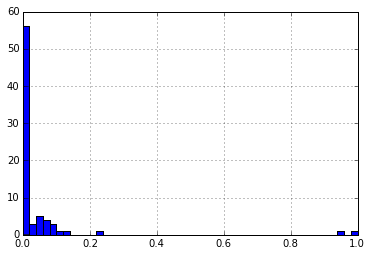

In [115]:
sdf[sdf['datatype']=='object'].y_arity.hist(bins=50)

In [116]:
len(sdf[sdf['datatype']=='object'])

76

In [120]:
sdf[(sdf['datatype']=='object') & (sdf['x_missing']<=missing_threshold) & (sdf['x_missing'] > 0)]

,Column,datatype,nmissing,arity,accepted values,x_missing,y_arity
0,ACTRES1,object,71,27931,None,0.000292,0.114938
2,ACTRES2,object,55228,24122,None,0.227266,0.099263
3,ACTRES3,object,94462,20617,None,0.388717,0.084840
14,ADDRESS1,object,127,231398,None,0.000523,0.952216
43,DIVISION_CODE_SFI,object,19,10,"[9, 6, 1, 2, 4, 3, 5, 7, 0, nan]",0.000078,0.000041
53,EXT_FUNC_ID_SFI,object,19,424,None,0.000078,0.001745
75,FUNC_ID_SFI,object,19,64,None,0.000078,0.000263
76,GRADE,object,526,165,None,0.002165,0.000679
89,JOB_FAMILY,object,84592,1496,None,0.348101,0.006156
90,JOB_FUNCTION,object,84623,20,None,0.348228,0.000082


In [124]:
empltbl[empltbl.STATE == 'NB'][['status','LOC_STATE','LOC_CITY','JOB_FUNCTION','zip5',']]

,status,LOC_STATE,LOC_CITY,JOB_FUNCTION,zip5
1730,1,CA,ROHNERT PARK,NaN,NaN
4383,1,MO,COLUMBIA,NaN,NaN
38300,1,MO,COLUMBIA,NaN,NaN


In [113]:
sdf.head()

,Column,datatype,nmissing,arity,accepted values,x_missing,y_arity
0,ACTRES1,object,71,27931,None,0.000292,0.114938
1,ACTRES10,object,162653,12402,None,0.669326,0.051035
2,ACTRES2,object,55228,24122,None,0.227266,0.099263
3,ACTRES3,object,94462,20617,None,0.388717,0.084840
4,ACTRES4,object,114253,18666,None,0.470158,0.076812


In [126]:
empltbl['PERF1'].value_counts()

0.00       72806
3748.50      295
3213.00      260
212.63       177
2677.50      160
196.88       151
1600.47      136
472.50       129
360.00       122
4284.00      118
1244.81      117
4123.35      114
4819.50      109
1422.64      105
294.00       101
417.00        98
3534.30       92
209.08        87
1956.13       72
271.67        70
195.35        69
163.00        68
291.90        67
168.75        67
630.00        64
5301.45       61
1066.98       61
375.00        59
531.56        57
1778.30       56
           ...  
63.89          1
8209.63        1
228.74         1
3926.35        1
7770.53        1
1091.86        1
2323.94        1
1286.77        1
1242.74        1
993.48         1
959.65         1
2425.58        1
1087.76        1
875.95         1
542.59         1
5806.04        1
2485.58        1
2631.44        1
1665.86        1
1188.14        1
1910.95        1
81.64          1
4149.27        1
869.10         1
5757.09        1
2435.08        1
1521.03        1
742.57        

In [ ]:
#for c in columns_to_fix_missing.values:
sdf.ix[columns_to_fix_missing.index][sdf['datatype'].ix[columns_to_fix_missing.index]=='object']
        

In [92]:
empltbl[empltbl.POSTAL_SFI.isnull()].zip5

27        nan
124       nan
541       nan
834       nan
835       nan
909       nan
993       nan
1118      nan
1435      nan
1595      nan
1730      nan
1953      nan
2152      nan
2195      nan
2473      nan
2521      nan
2796      nan
2890      nan
2923      nan
2979      nan
3073      nan
3510      nan
4383      nan
4471      nan
4595      nan
4657      nan
4856      nan
4858      nan
4918      nan
5116      nan
         ... 
89018     nan
91303     nan
94506     nan
96172     nan
99276     nan
99664     nan
102169    nan
102905    nan
105348    nan
105835    nan
107427    nan
107572    nan
108035    nan
109803    nan
111909    nan
126617    nan
127174    nan
130046    nan
133000    nan
133034    nan
135811    nan
139788    nan
141996    nan
143849    nan
146260    nan
147144    nan
149110    nan
149916    nan
157195    nan
162083    nan
Name: zip5, dtype: object

In [110]:
empltbl.ACTRES1.tail()

70604    MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...
70605    MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...
70606    MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...
70607    MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...
70608    MISCELLANEOUS DATA CHANGE;MISCELLANEOUS DATA C...
Name: ACTRES1, dtype: object

In [108]:
# omit those that have more than 40% missing:
columns_to_omit = sdf[sdf['x_missing'] > missing_threshold].Column.values
print len(columns_to_omit)
columns_to_omit

29

In [173]:
# omit those that have more than 40% missing:
missing_threshold = 0.27
columns_to_omit = list(sdf[sdf['x_missing'] > missing_threshold].Column.values)
print len(columns_to_omit)
#columns_to_omit

61


In [174]:
# add the ACTRES2/3 and ADDRESS1/2 lines
# add *_tdelta, BIRTHDATE, PER_ORG
# add POSTAL_SFI, zip5, MAR_STA_SNAME_SFI, LOC_TYPE_DESC_SFI
others_to_omit = ['ADDRESS1','Age_tdelta','BIRTHDATE','LAST_HIRE_DT',
                  'LOC_CITY','LOC_TYPE_DESCR_SFI','MAR_STATUS_DT','MAR_STA_SNAME_SFI',
                  'PER_ORG','POSTAL_SFI','SKEY','SERVICE_DT','TERMINATION_DT',
                  'Tenure_tdelta','zip5']
                 #'MERIT1','MERIT2','MERIT3','MERIT4','MERIT5','MERIT6','MERIT7','MERIT8','MERIT9','MERIT10',
                 #'PERF1','PERF2','PERF3','PERF4','PERF5','PERF6','PERF7','PERF8','PERF9','PERF10']
history_to_omit = ['ADDRCNT10','ADDRCNT3','ADDRCNT5','DEPTCNT10','DEPTCNT3','DEPTCNT5',
                   'EFUNCCNT10','EFUNCCNT3','EFUNCCNT5','FLOORCNT10','FLOORCNT3','FLOORCNT5',
                  'FTPTCNT10','FTPTCNT3','FTPTCNT5','FULLPART10','FULLPART3','FULLPART5',
                  'FUNCCNT10','FUNCCNT3','FUNCCNT5','GRADECNT10','GRADECNT3','GRADECNT5',
                  'JOBCNT10','JOBCNT3','JOBCNT5','LOCCNT10','LOCCNT3','LOCCNT5','LOCSTCNT10','LOCSTCNT3','LOCSTCNT5',
                  'PARTFULL10','PARTFULL3','PARTFULL5','PTFTCNT10','PTFTCNT3','PTFTCNT5',
                   'SUPVCNT10','SUPVCNT3','SUPVCNT5','ACTRES2']
cols_to_categorical = ['COMPANY','COMP_FREQUENCY','DIVISION_CODE_SFI','EEO1CODE','EMPL_CLASS','EMPL_TYPE','ETHNIC_GROUP',
                       'FLSA_STATUS','FULLPART1','FULL_PART_TIME','HUBIND','INTERN','JOB_FUNCTION','RELOCATE_ALL_SFI',
                       'REMOTE','REMOTE_SUPV','SEX','SHIFT','SUPV_DIFF_LOC','VOLINVOL','status']
for col in others_to_omit:
    columns_to_omit.append(col)

for col in history_to_omit:
    columns_to_omit.append(col)
    
print len(columns_to_omit),len(cols_to_categorical)

119 21


In [175]:
# add JOB_FAMILY and JOB_FUNCTION back into those to keep
columns_to_omit.remove('JOB_FAMILY')
columns_to_omit.remove('JOB_FUNCTION')

len(columns_to_omit)

117

In [176]:
# define columns to keep
columns_to_keep = list(set(empltbl.columns)-set(columns_to_omit))
len(columns_to_keep)

69

In [177]:
sort(columns_to_keep)

array(['ACTRES1', 'ADDRCNT1', 'ANNUAL_RT', 'Age_years', 'COMPANY',
       'COMP_FREQUENCY', 'CUR_DEPT_MOS', 'CUR_EFUNC_MOS', 'CUR_FUNC_MOS',
       'CUR_GRADE_MOS', 'CUR_JOB_MOS', 'CUR_LOC_MOS', 'DEPTCNT1',
       'DIRECT_RPT_CNT', 'DIVISION_CODE_SFI', 'EEO1CODE', 'EFUNCCNT1',
       'EMPL_CLASS', 'EMPL_TYPE', 'ETHNIC_GROUP', 'EXTFUNC_CNT',
       'EXT_FUNC_ID_SFI', 'FLOORCNT1', 'FLOR_SFI', 'FLSA_STATUS', 'FTE',
       'FTPTCNT1', 'FULLPART1', 'FULL_PART_TIME', 'FUNCCNT1', 'FUNC_CNT',
       'FUNC_ID_SFI', 'GRADE', 'GRADECNT1', 'HIRE_DT', 'HUBIND', 'INTERN',
       'JOBCNT1', 'JOBCODE', 'JOB_FAMILY', 'JOB_FUNCTION', 'KEY',
       'LEGACY_DEPT_SFI', 'LOCATION', 'LOCCNT1', 'LOCSTCNT1', 'LOC_STATE',
       'MAX_RT_ANNUAL', 'MIN_RT_ANNUAL', 'PARTFULL1', 'PTFTCNT1',
       'REH_CNT', 'RELOCATE_ALL_SFI', 'RELO_STATE_CNT_SFI', 'REMOTE',
       'REMOTE_SUPV', 'SAL1', 'SEX', 'SHIFT', 'STATE', 'STD_HOURS',
       'SUPVCNT1', 'SUPV_DIFF_LOC', 'TELE_MOS', 'TOTAL_RPT_CNT',
       'TOT_MO_SERVICE_SF

In [178]:
reduced_tbl = empltbl[columns_to_keep].copy()
reduced_tbl.shape

(243010, 69)

In [180]:
for cat_col in cols_to_categorical:
    reduced_tbl[cat_col] = reduced_tbl[cat_col].astype('category')


In [ ]:
reduced_summary_df = summarize_dataframe2(red_tbl)

In [181]:
reduced_tbl.head()

,EXT_FUNC_ID_SFI,EMPL_CLASS,REH_CNT,FLOR_SFI,FULL_PART_TIME,ACTRES1,EEO1CODE,SHIFT,FUNCCNT1,LOC_STATE,...,DIRECT_RPT_CNT,LOCCNT1,PARTFULL1,KEY,DEPTCNT1,FUNC_ID_SFI,EMPL_TYPE,CUR_FUNC_MOS,CUR_DEPT_MOS,COMP_FREQUENCY
0,99999,1,0,999,X,NORMAL RETIREMENT,N,N,0,NaN,...,NaN,0,N,880033485535548,0,99999,N,0,0,A
1,00077,1,0,999,F,ANOTHER OPPORTUNITY;COMPANY WIDE CONVERSION;RE...,2,N,0,MI,...,NaN,0,N,136991961922958,0,00001,E,0,0,A
2,00321,1,0,999,F,ANOTHER OPPORTUNITY;COMPANY WIDE CONVERSION;RE...,2,N,0,MD,...,NaN,0,N,12306951923439,0,00004,E,0,0,A
3,00321,1,0,999,F,ANOTHER OPPORTUNITY;COMPANY WIDE CONVERSION;RE...,2,N,0,AZ,...,NaN,0,N,281250500251190,0,00004,E,0,0,A
4,00094,1,0,999,F,ANOTHER OPPORTUNITY;COMPANY WIDE CONVERSION;RE...,6,N,0,TX,...,NaN,0,N,942534502103242,0,00006,E,0,0,A


In [184]:
reduced_tbl.columns

Index([u'EXT_FUNC_ID_SFI', u'EMPL_CLASS', u'REH_CNT', u'FLOR_SFI', u'FULL_PART_TIME', u'ACTRES1', u'EEO1CODE', u'SHIFT', u'FUNCCNT1', u'LOC_STATE', u'JOB_FUNCTION', u'INTERN', u'GRADE', u'TELE_MOS', u'SUPVCNT1', u'ANNUAL_RT', u'LEGACY_DEPT_SFI', u'CUR_LOC_MOS', u'JOB_FAMILY', u'TOT_MO_SERVICE_SFI', u'Age_years', u'COMPANY', u'CUR_JOB_MOS', u'MAX_RT_ANNUAL', u'FUNC_CNT', u'SEX', u'FULLPART1', u'ETHNIC_GROUP', u'RELOCATE_ALL_SFI', u'LOCATION', u'HUBIND', u'Tenure_months', u'STD_HOURS', u'JOBCNT1', u'FLOORCNT1', u'MIN_RT_ANNUAL', u'PTFTCNT1', u'FLSA_STATUS', u'FTPTCNT1', u'CUR_GRADE_MOS', u'GRADECNT1', u'EFUNCCNT1', u'STATE', u'CUR_EFUNC_MOS', u'FTE', u'TOTAL_RPT_CNT', u'SAL1', u'HIRE_DT', u'LOCSTCNT1', u'VOLINVOL', u'status', u'REMOTE', u'REMOTE_SUPV', u'JOBCODE', u'SUPV_DIFF_LOC', u'DIVISION_CODE_SFI', u'ADDRCNT1', u'RELO_STATE_CNT_SFI', u'EXTFUNC_CNT', u'DIRECT_RPT_CNT', u'LOCCNT1', u'PARTFULL1', u'KEY', u'DEPTCNT1', u'FUNC_ID_SFI', u'EMPL_TYPE', u'CUR_FUNC_MOS', u'CUR_DEPT_MOS', u'COM

In [191]:
pd.crosstab(reduced_tbl['REMOTE'],reduced_tbl['HUBIND'])

HUBIND,N,Y
REMOTE,,
N,161832,63150
Y,18028,0


In [196]:
pd.crosstab(reduced_tbl['FTPTCNT1'],reduced_tbl['PTFTCNT1'])

PTFTCNT1,0,1,2
FTPTCNT1,,,
0,239321,1949,0
1,1630,104,2
2,0,4,0


In [208]:
reduced_tbl.FULL_PART_TIME.value_counts()

F    182869
P     29328
N     26093
X      4720
dtype: int64

In [ ]:
## further reduce by removing
FULL_PART_TIME, ACTRES1, KEY, 

In [205]:
len(reduced_tbl.JOB_FAMILY.unique()), len(reduced_tbl.JOB_FUNCTION.unique()), len(reduced_tbl.GRADE.unique()),len(reduced_tbl.JOBCODE.unique())

(1496, 20, 165, 3835)

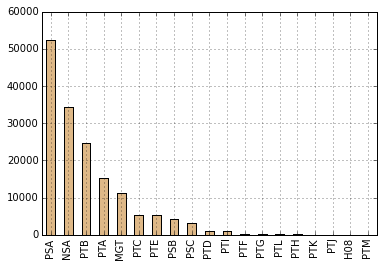

In [202]:
reduced_tbl.JOB_FUNCTION.value_counts().plot(kind='bar',color='burlywood')

In [ ]:
reduced_tbl.GRADE.value_counts().plot(kind='bar',color='burlywood')

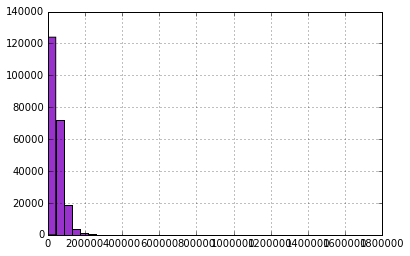

In [221]:
#sum(reduced_tbl.MAX_RT_ANNUAL==0)
reduced_tbl[reduced_tbl.ANNUAL_RT!=0].ANNUAL_RT.hist(bins=40,color='darkorchid')

In [217]:
sum(reduced_tbl.ANNUAL_RT==0)

23280

In [223]:
reduced_tbl['JOB_FUNCTION'].unique()

array([nan, 'NSA', 'PTB', 'PSA', 'MGT', 'PTA', 'PSB', 'PTC', 'PSC', 'PTI',
       'PTF', 'PTE', 'PTH', 'PTG', 'PTD', 'PTJ', 'PTM', 'PTL', 'H08', 'PTK'], dtype=object)

In [285]:
initial_columns_list = ['SEX','INTERN','FULL_PART_TIME']#,'COMPANY','VOLINVOL']#'JOB_FUNCTION','COMPANY','HUBIND','VOLINVOL']
sum(reduced_tbl[initial_columns_list].isnull())

SEX               0
INTERN            0
FULL_PART_TIME    0
dtype: int64

In [235]:
jf_hold = reduced_tbl.JOB_FUNCTION.astype('object')
jf_hold.fillna('XXX',inplace=True)
reduced_tbl['JOB_FUNCTION'] = jf_hold
reduced_tbl['JOB_FUNCTION'] = reduced_tbl['JOB_FUNCTION'].astype('category')

In [314]:
initial_columns_list = ['SEX','Age_years','INTERN','FULL_PART_TIME','JOB_FUNCTION','COMPANY','HUBIND','VOLINVOL']
sum(reduced_tbl[initial_columns_list].isnull())

SEX               0
Age_years         0
INTERN            0
FULL_PART_TIME    0
JOB_FUNCTION      0
COMPANY           0
HUBIND            0
VOLINVOL          0
dtype: int64

In [ ]:
#pull out the reduced columns
fill_flag = True
reduced2 = reduced_tbl[initial_columns_list].copy()
for c in reduced2.columns:
    nmissing = sum(reduced2[c].isnull())
    datatype = reduced2[c].dtype
    if nmissing > 0 and fill_flag:
        if datatype=='category':
            reduced2[c].fillna('XNA',inplace=True)
    
        
    print c, reduced2[c].dtype

In [315]:
reduced2 = reduced_tbl[initial_columns_list].copy()
reduced2.shape

(243010, 8)

In [316]:
dummy_columns_list1 = list(reduced2.columns) #['SEX','INTERN','FULL_PART_TIME','JOB_FUNCTION','COMPANY','HUBIND','VOLINVOL']

In [317]:
# create a dummified dataframe.
reduced_dummies = pd.get_dummies(reduced2[dummy_columns_list1])
print reduced_dummies.shape    

(243010, 43)


In [318]:
dummy_column_list2 = list(reduced_dummies.columns)

In [319]:
dummy_col_to_drop = []
for col in dummy_columns_list1:
    dclist = [x for x in dummy_column_list2 if x.startswith(col)]
    print dclist
    dummy_col_to_drop.append(dclist[0])

dummy_col_to_keep = list(set(dummy_column_list2) - set(dummy_col_to_drop))

reduced3 = reduced_dummies[dummy_col_to_keep].copy()
#add the non-categorical back in
#reduced3[initial_columns_list[1]] = reduced2[initial_columns_list[1]]
reduced3.shape

['SEX_F', 'SEX_M']
['Age_years']
['INTERN_N', 'INTERN_Y']
['FULL_PART_TIME_F', 'FULL_PART_TIME_N', 'FULL_PART_TIME_P', 'FULL_PART_TIME_X']
['JOB_FUNCTION_H08', 'JOB_FUNCTION_MGT', 'JOB_FUNCTION_NSA', 'JOB_FUNCTION_PSA', 'JOB_FUNCTION_PSB', 'JOB_FUNCTION_PSC', 'JOB_FUNCTION_PTA', 'JOB_FUNCTION_PTB', 'JOB_FUNCTION_PTC', 'JOB_FUNCTION_PTD', 'JOB_FUNCTION_PTE', 'JOB_FUNCTION_PTF', 'JOB_FUNCTION_PTG', 'JOB_FUNCTION_PTH', 'JOB_FUNCTION_PTI', 'JOB_FUNCTION_PTJ', 'JOB_FUNCTION_PTK', 'JOB_FUNCTION_PTL', 'JOB_FUNCTION_PTM', 'JOB_FUNCTION_XXX']
['COMPANY_001', 'COMPANY_002', 'COMPANY_003', 'COMPANY_004', 'COMPANY_005', 'COMPANY_007', 'COMPANY_049']
['HUBIND_N', 'HUBIND_Y']
['VOLINVOL_INVOLUNTARY', 'VOLINVOL_NOT', 'VOLINVOL_OTHER', 'VOLINVOL_UNKNOWN', 'VOLINVOL_VOLUNTARY']


(243010, 35)

In [320]:
## add in status and time
reduced3['Age'] = empltbl['Age_years']
reduced3['status'] = empltbl['status']
reduced3['Tenure'] = empltbl['Tenure_months']

## Aalen's Additive model

In [292]:
from lifelines import AalenAdditiveFitter
reduced3.head()

,INTERN_Y,SEX_M,FULL_PART_TIME_X,FULL_PART_TIME_N,FULL_PART_TIME_P,Age,status,Tenure
0,0,1,1,0,0,65.055408,1,266.978788
1,0,0,0,0,0,23.116149,1,7.030945
2,0,1,0,0,0,25.889649,1,4.501119
3,0,0,0,0,0,26.973860,1,4.501119
4,0,1,0,0,0,24.419393,1,22.209902


In [293]:
reduced3.columns

Index([u'INTERN_Y', u'SEX_M', u'FULL_PART_TIME_X', u'FULL_PART_TIME_N', u'FULL_PART_TIME_P', u'Age', u'status', u'Tenure'], dtype='object')

In [311]:
aaf_tenure = AalenAdditiveFitter(penalizer=1.0,fit_intercept=True)

In [312]:
aaf_tenure.fit(reduced3,'Tenure',event_col='status')

 [-----------------100%-----------------] 172401 of 172401 complete in 5632.8 sec


<lifelines.AalenAdditiveFitter: fitted with 243010 observations, 70609 censored>

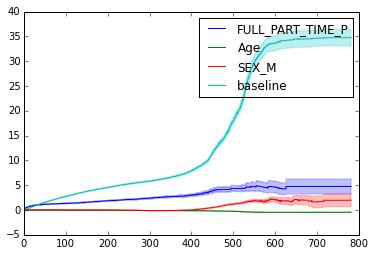

In [313]:
aaf_tenure.plot(columns=['FULL_PART_TIME_P','Age','SEX_M','baseline'])

In [321]:
aaf_tenure_b = AalenAdditiveFitter(penalizer=1.0,fit_intercept=True)

In [330]:
reduced3.shape

(243010, 38)

In [ ]:
aaf_tenure_b.fit(reduced3,'Tenure',event_col='status')

 [                  0%                  ] 181 of 172401 complete in 71.4 sec

## CoxPH

In [297]:
from lifelines import CoxPHFitter

In [299]:
cf_tenure = CoxPHFitter()
cf_tenure.fit(reduced3,'Tenure',event_col='status')


<lifelines.CoxPHFitter: fitted with 243010 observations, 70609 censored>

In [301]:
cf_tenure.summary()

n=243010, number of events=172401

                       coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
INTERN_Y          2.200e-01  1.246e+00 2.577e-03  8.535e+01 0.000e+00   2.149e-01   2.250e-01  ***
SEX_M            -1.423e-02  9.859e-01 2.485e-03 -5.728e+00 1.017e-08  -1.910e-02  -9.360e-03  ***
FULL_PART_TIME_X  2.625e-02  1.027e+00 2.126e-03  1.235e+01 4.928e-35   2.208e-02   3.042e-02  ***
FULL_PART_TIME_N  3.448e-01  1.412e+00 2.580e-03  1.336e+02 0.000e+00   3.397e-01   3.498e-01  ***
FULL_PART_TIME_P  3.697e-01  1.447e+00 2.485e-03  1.488e+02 0.000e+00   3.649e-01   3.746e-01  ***
Age              -9.982e-01  3.686e-01 3.967e-03 -2.516e+02 0.000e+00  -1.006e+00  -9.904e-01  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.792


In [302]:
cf_tenure.plot(columns=['FULL_PART_TIME_P','Age','SEX_M','baseline'])

AttributeError: 'CoxPHFitter' object has no attribute 'plot'

In [307]:
cf_tenure.hazards_

,INTERN_Y,SEX_M,FULL_PART_TIME_X,FULL_PART_TIME_N,FULL_PART_TIME_P,Age
coef,0.219968,-0.014231,0.026252,0.344751,0.369729,-0.998159


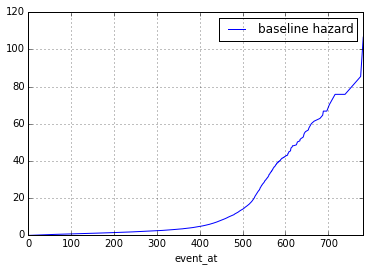

In [305]:
cf_tenure.baseline_cumulative_hazard_.plot()

In [329]:
sample1 = np.array([0,1,0,0,0,55])
s1value = np.dot(cf_tenure.hazards_.values[0],sample1)
np.exp(s1value)

1.4177666329501168e-24

In [323]:
cf_tenure.baseline_cumulative_hazard_.head()

,baseline hazard
event_at,
0.000000,0.000452
0.032855,0.000772
0.065710,0.001075
0.098565,0.001370
0.131420,0.001862


In [309]:
reduced3.index = np.arange(0,len(reduced3))

In [310]:
# k-fold

from lifelines.utils import k_fold_cross_validation

#regression_dataset = load_regression_dataset()
cf = CoxPHFitter()
scores = k_fold_cross_validation(cf, reduced3, 'Tenure', event_col='status', k=5)
print scores
print scores.mean()
print scores.std()

[ 0.5  0.5  0.5  0.5  0.5]
0.5
0.0


In [239]:
import patsy

In [240]:
X = patsy.dmatrix('SEX + JOB_FUNCTION + Age_years + INTERN + COMPANY + VOLINVOL + HUBIND - 1', reduced2, return_type='dataframe')

TypeError: data type not understood

In [210]:
patsy.__version__

'0.3.0'

In [332]:
# now use lifelines
from lifelines import KaplanMeierFitter

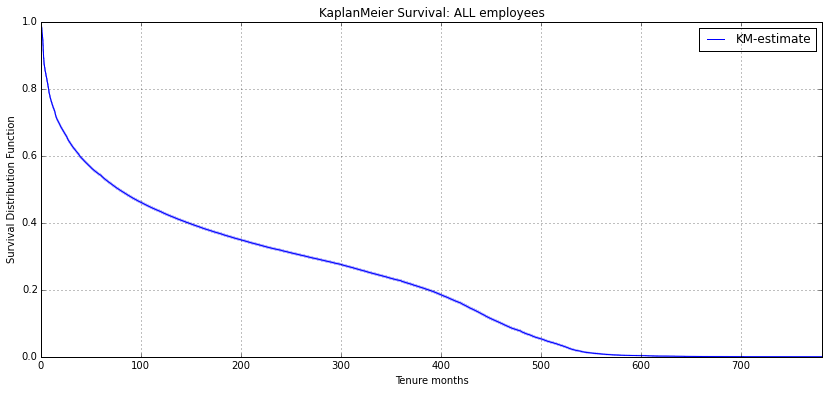

In [333]:
figsize(14,6)
kmf = KaplanMeierFitter()
kmf.fit(empltbl.Tenure_months, event_observed=empltbl.status)
kmf.plot()
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure months')
plt.title('KaplanMeier Survival: ALL employees')

In [344]:
empltbl.DIVISION_CODE_SFI.value_counts()

9    148161
0     31899
2     13456
1     12917
4      9413
3      9213
5      8906
6      7630
7      1396
dtype: int64

In [351]:
cur_empl.GRADE.value_counts()

RB2    11152
PA2     9672
PA3     7694
PA1     4580
RA3     4519
RA2     4436
MG3     3986
PA4     2686
RB1     2039
RE3     1783
RA4     1763
RE4     1748
RC2     1742
MG2     1613
MG4     1562
RA1     1218
RB3     1033
PC3      910
RC1      821
UNS      803
MG5      519
FA6      506
RE2      481
UES      377
PC4      347
RC3      288
RD3      265
RD2      252
RD4      244
MG1      154
       ...  
RL4        6
RJ2        6
IF3        6
IJA        5
IM1        5
IF4        4
IM3        4
BC4        4
L4         4
AT3        3
IE2        3
RJ4        2
MG7        2
IS3        2
AT7        2
RH4        1
IE3        1
RG1        1
AT8        1
AT1        1
AT4        1
L3         1
L1         1
IOO        1
AT6        1
IS1        1
IM4        1
RJ3        1
ISM        1
AT2        1
dtype: int64

In [334]:
empltbl.JOB_FUNCTION.unique()

array([nan, 'NSA', 'PTB', 'PSA', 'MGT', 'PTA', 'PSB', 'PTC', 'PSC', 'PTI',
       'PTF', 'PTE', 'PTH', 'PTG', 'PTD', 'PTJ', 'PTM', 'PTL', 'H08', 'PTK'], dtype=object)

In [335]:
empltbl.JOB_FUNCTION.value_counts()

PSA    52291
NSA    34337
PTB    24755
PTA    15322
MGT    11111
PTC     5268
PTE     5239
PSB     4212
PSC     3115
PTD      965
PTI      955
PTF      280
PTG      188
PTL      167
PTH      124
PTK       28
PTJ       21
H08        7
PTM        2
dtype: int64

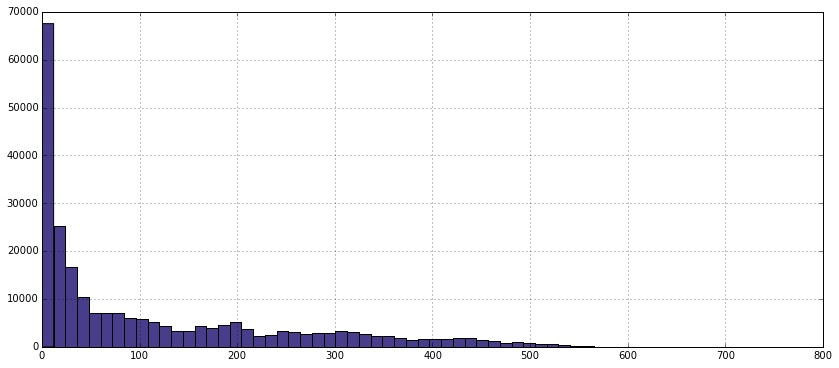

In [343]:
empltbl.Tenure_months.hist(bins=65,color='darkslateblue')

In [341]:
mgt = empltbl[empltbl['JOB_FUNCTION'] == 'MGT']
psa = empltbl[empltbl['JOB_FUNCTION'] == 'PSA']
nsa = empltbl[empltbl['JOB_FUNCTION'] == 'NSA']
len(psa), len(mgt), len(nsa)

(52291, 11111, 34337)

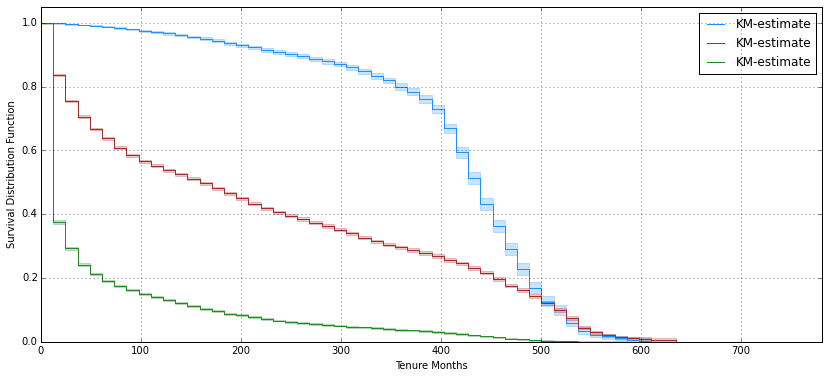

In [342]:
kmf_jf1 = KaplanMeierFitter()
#plt.figure(figsize=(20,10))
kmf_jf1.fit(mgt.Tenure_months, timeline=tenure_month_range,event_observed=mgt.status)
ax = kmf_jf1.plot(c='dodgerblue',label='MGT')
kmf_jf1.fit(psa.Tenure_months,  timeline=tenure_month_range,event_observed=psa.status)
kmf_jf1.plot(ax=ax, c='brown',label='PSA')
kmf_jf1.fit(nsa.Tenure_months,  timeline=tenure_month_range,event_observed=nsa.status)
kmf_jf1.plot(ax=ax, c='forestgreen',label='NSA')

ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

In [354]:
mgt.GRADE.value_counts()

MG3    5615
MG2    2198
MG4    2045
MG5     762
MG1     193
MG6     150
UES     129
AM4      12
MG7       3
ZFL       1
RA1       1
MA6       1
MA4       1
dtype: int64

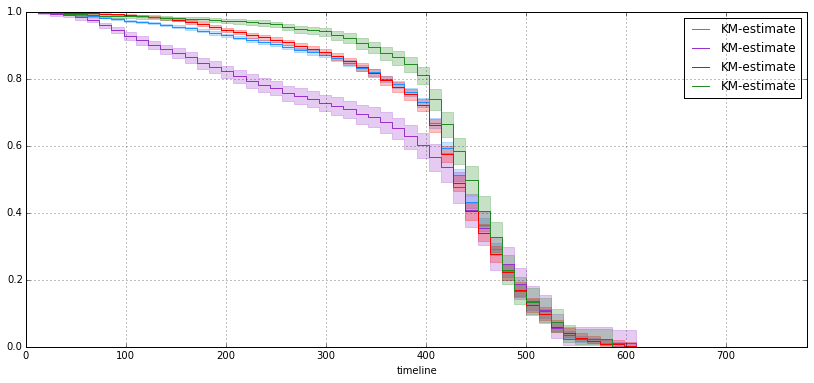

In [357]:
mgt = empltbl[empltbl['JOB_FUNCTION'] == 'MGT'].copy()
mg1 = mgt[mgt.GRADE == 'MG1']
mg2 = mgt[mgt.GRADE == 'MG2']
mg3 = mgt[mgt.GRADE == 'MG3']
mg4 = mgt[mgt.GRADE == 'MG4']
kmf_mg = KaplanMeierFitter()
#plt.figure(figsize=(20,10))
kmf_mg.fit(mgt.Tenure_months, timeline=tenure_month_range,event_observed=mgt.status)
ax = kmf_mg.plot(c='dodgerblue',label='MGT')
#kmf_mg.fit(mg1.Tenure_months, timeline=tenure_month_range,event_observed=mg1.status)
#kmf_mg.plot(c='darkslategray',label='MG1')
kmf_mg.fit(mg2.Tenure_months, timeline=tenure_month_range,event_observed=mg2.status)
kmf_mg.plot(ax=ax, c='darkorchid',label='MG2')

kmf_mg.fit(mg3.Tenure_months, timeline=tenure_month_range,event_observed=mg3.status)
kmf_mg.plot(ax=ax, c='red',label='MG3')
kmf_mg.fit(mg4.Tenure_months, timeline=tenure_month_range,event_observed=mg4.status)
kmf_mg.plot(ax=ax, c='forestgreen',label='MG4')



In [269]:
kmf.survival_function_

,KM-estimate
timeline,
0.000000,0.999092
0.032855,0.998454
0.065710,0.997826
0.098565,0.997292
0.131420,0.996472
0.164274,0.996415
0.197129,0.996244
0.229984,0.995673
0.262839,0.995195


### look at difference between M & F

In [530]:
male = empltbl[empltbl['SEX'] =='M']
female = empltbl[empltbl['SEX'] =='F']
len(male),len(female)

(90620, 152382)

In [531]:
male.Tenure_months.describe(), female.Tenure_months.describe()

(count    90620.000000
 mean       125.097521
 std        139.808186
 min          0.000000
 25%         11.400645
 50%         60.732253
 75%        209.614160
 max        781.519128
 dtype: float64, count    152382.000000
 mean        109.818388
 std         131.786893
 min           0.000000
 25%           8.870819
 50%          45.438305
 75%         181.556089
 max         738.972053
 dtype: float64)

In [338]:
min_tenure_months= empltbl.Tenure_months.min()
max_tenure_months = empltbl.Tenure_months.max()
print min_tenure_months, max_tenure_months
tenure_month_range = np.linspace(min_tenure_months,max_tenure_months,65)
len(tenure_month_range)

0.0 781.519127703


65

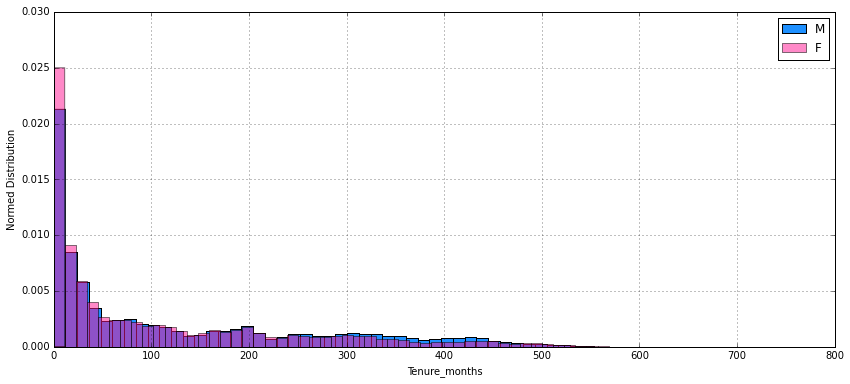

In [533]:
male.Tenure_months.hist(normed=True,color='dodgerblue',bins=65,label='M')
female.Tenure_months.hist(normed=True,color='deeppink',alpha=0.5,bins=65,label='F')
plt.xlabel('Tenure_months')
plt.ylabel('Normed Distribution')
plt.legend()

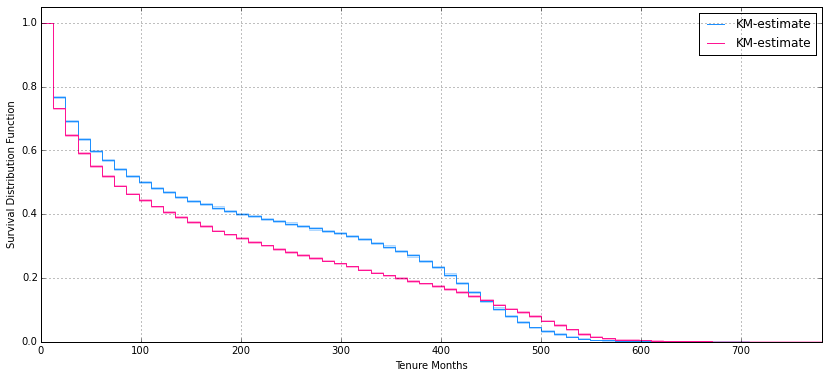

In [534]:
kmf_gender = KaplanMeierFitter()
#plt.figure(figsize=(20,10))
kmf_gender.fit(male.Tenure_months, timeline=tenure_month_range,event_observed=male.status)
ax = kmf_gender.plot(c='dodgerblue',label='Male')
kmf_gender.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
kmf_gender.plot(ax=ax, c='deeppink',label='Female')
ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Tenure Months')

## Hazard Function

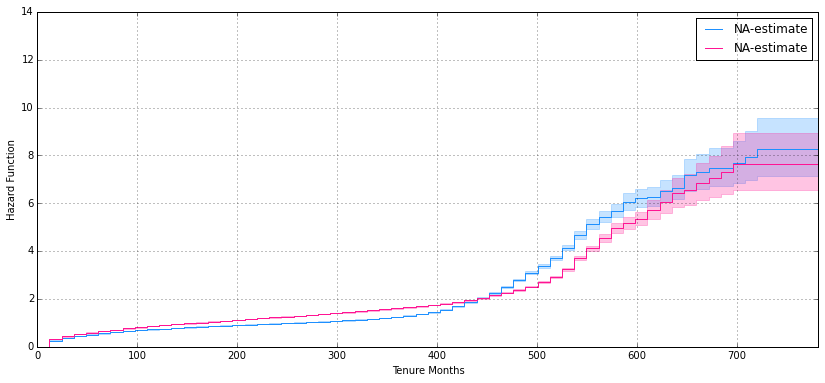

In [535]:
from lifelines import NelsonAalenFitter
#plt.figure(figsize=(12.5,8))
naf = NelsonAalenFitter()
naf.fit(male.Tenure_months,timeline=tenure_month_range, event_observed=male.status)
ax = naf.plot(c='dodgerblue',label='Male')
naf.fit(female.Tenure_months,  timeline=tenure_month_range,event_observed=female.status)
naf.plot(ax=ax, c='deeppink',label='Female')
#ylim(0,1.05)
plt.ylabel('Hazard Function')
plt.xlabel('Tenure Months')
#fit(male.Tenure_months,timeline=tenure_month_range, event_observed=male.status)

### Repeat using age in years as timeline

In [536]:
empltbl.Age_years.describe()

count    243002.000000
mean         39.142082
std          13.380317
min          14.609472
25%          27.729522
50%          36.863180
75%          49.958589
max          98.197773
dtype: float64

In [537]:
sum(empltbl.Age_years > 80)

37

In [353]:
min_age = empltbl.Age_years.min()
max_age = empltbl.Age_years.max()
print min_age, max_age, max_age - min_age
delta_age= int(max_age - min_age)
age_range = np.linspace(min_age,max_age,delta_age)
len(age_range)

15.263831564 98.1977727126 82.9339411487


82

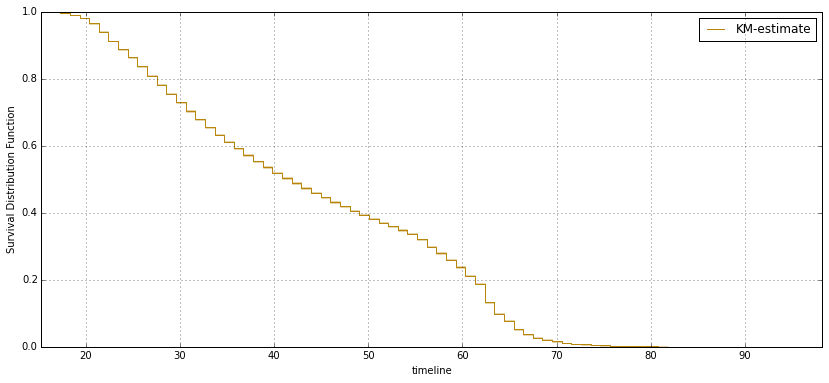

In [538]:
kmf_age = KaplanMeierFitter()
kmf_age.fit(empltbl.Age_years, timeline=age_range,event_observed=empltbl.status)
kmf_age.plot(color='darkgoldenrod')
plt.ylabel('Survival Distribution Function')

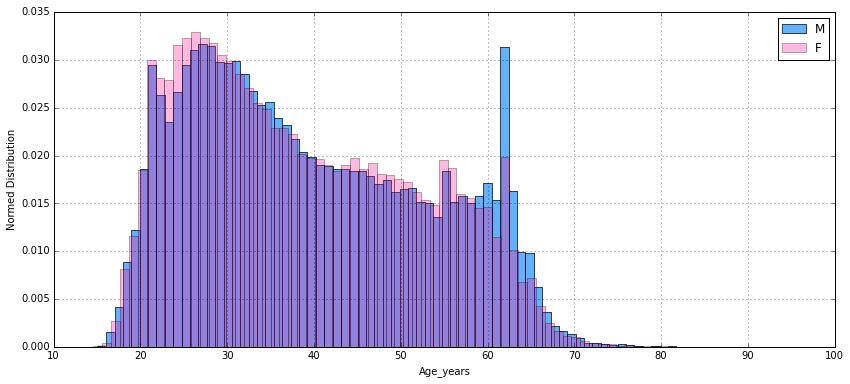

In [539]:
male.Age_years.hist(normed=True,color='dodgerblue',bins=82,alpha=0.7,label='M')
female.Age_years.hist(normed=True,color='deeppink',alpha=0.3,bins=82,label='F')
plt.xlabel('Age_years')
plt.ylabel('Normed Distribution')
plt.legend()

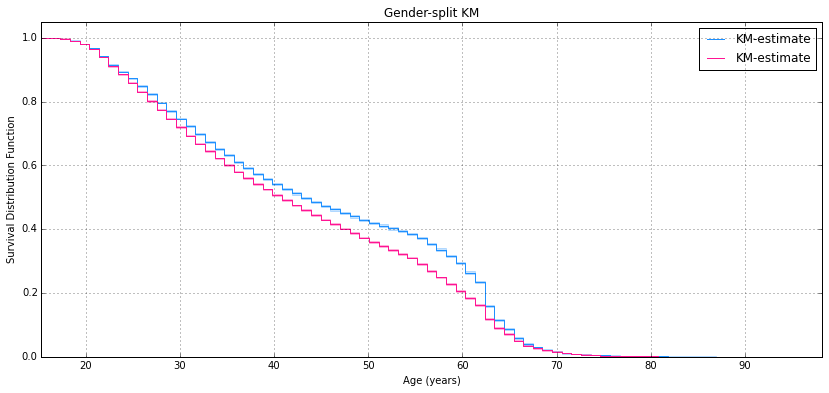

In [540]:
kmf_gender_age = KaplanMeierFitter()
#plt.figure(figsize=(20,10))
kmf_gender_age.fit(male.Age_years, timeline=age_range,event_observed=male.status)
ax = kmf_gender_age.plot(c='dodgerblue',label='Male')
kmf_gender_age.fit(female.Age_years,  timeline=age_range,event_observed=female.status)
kmf_gender_age.plot(ax=ax, c='deeppink',label='Female')
ylim(0,1.05)
plt.ylabel('Survival Distribution Function')
plt.xlabel('Age (years)')
plt.title('Gender-split KM')

## Cox Proportional Hazard Regression


In [541]:
from lifelines import CoxPHFitter

### restrict the dataframe to do linear-regression on.
* first attempt is _ad hoc_ reduction of 185 columns
    * keep age_years, tenure_months, status, sex for sure
* look at cases where there is 'significant' correlation between columns:
    * for example JOBCNTx, LOCCNTx, DEPTCNTx, ...

In [542]:
empltbl.shape

(243002, 183)

In [ ]:
plt.scatter(empltbl.FLOORCNT1,empltbl.DEPTCNT1,color='burlywood',alpha=0.3)

In [371]:
#pd.crosstab(empltbl, index = 'JOBCNT1',columns =
#(empltbl, 
empltbl[['JOBCNT1','LOCCNT1','DEPTCNT1','GRADECNT1','FLOORCNT1','SUPVCNT1']].corr()

,JOBCNT1,LOCCNT1,DEPTCNT1,GRADECNT1,FLOORCNT1,SUPVCNT1
JOBCNT1,1.000000,0.329361,0.438596,0.721679,0.168862,0.288238
LOCCNT1,0.329361,1.000000,0.614073,0.228802,0.188673,0.326542
DEPTCNT1,0.438596,0.614073,1.000000,0.251160,0.283301,0.441145
GRADECNT1,0.721679,0.228802,0.251160,1.000000,0.106899,0.190856
FLOORCNT1,0.168862,0.188673,0.283301,0.106899,1.000000,0.114109
SUPVCNT1,0.288238,0.326542,0.441145,0.190856,0.114109,1.000000


In [444]:
c='EMPL_CLASS'
empltbl[c].value_counts()

1    237717
D      2985
3      1348
T       490
O       339
4        60
X        30
P        13
5         9
2         9
G         1
F         1
dtype: int64

In [445]:

len(empltbl[c].unique())

12

,ANNUAL_RT,SAL1
ANNUAL_RT,1,1
SAL1,1,1


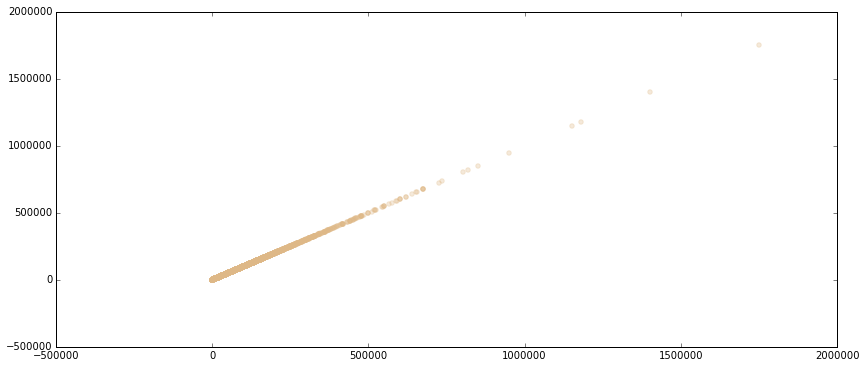

In [544]:
plt.scatter(empltbl.ANNUAL_RT,empltbl.SAL1,color='burlywood',alpha=0.3)
empltbl[['ANNUAL_RT','SAL1']].corr()

In [456]:
len(empltbl[empltbl.ANNUAL_RT>0])

219722

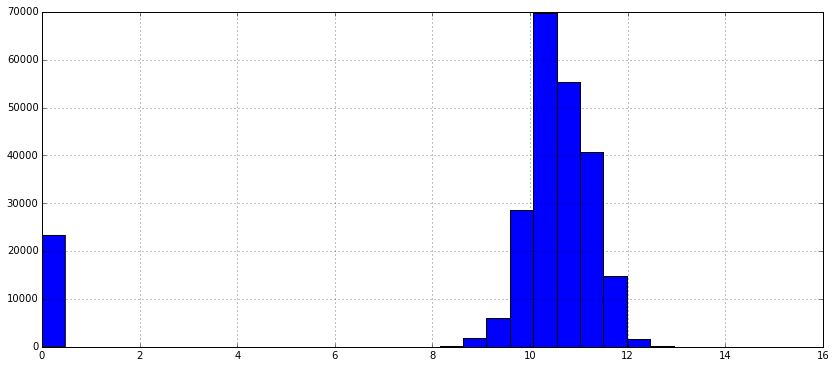

In [545]:
np.log(empltbl.ANNUAL_RT+1).hist(bins=30)

count     192736.000000
mean       46438.526873
std        36610.289517
min            0.000000
25%        25000.000000
50%        37768.265000
75%        63171.840000
max      1750000.000000
dtype: float64

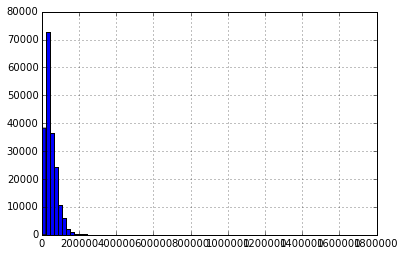

In [376]:
empltbl.SAL1.hist(bins=80)
empltbl.SAL1.describe()

In [377]:
sum(empltbl.SAL1 == 0.0)

18566

In [384]:
ret_empl[ret_empl.KEY==dup_empl_keys[2]][['TOT_MO_SERVICE_SFI','Tenure_months']]#.head()

,TOT_MO_SERVICE_SFI,Tenure_months
145871,34,34.497628
145872,34,34.497628


In [385]:
empltbl.RELOCATE_ALL_SFI.value_counts()

N    171218
Y     21518
dtype: int64

In [ ]:
empltbl.LOCATION.value_counts().hist(bins=50)

In [588]:
empltbl.LOC_STATE.unique()

array([nan, 'MI', 'MD', 'AZ', 'TX', 'LA', 'AL', 'PA', 'FL', 'CA', 'IL',
       'OH', 'VA', 'OR', 'MN', 'MO', 'WI', 'IN', 'NY', 'NC', 'NJ', 'CO',
       'NM', 'KY', 'UT', 'TN', 'NE', 'WV', 'WA', 'NV', 'MT', 'DE', 'AR',
       'ID', 'IA', 'SD', 'WY', 'OK', 'KS', 'ND', 'AK', 'GA', 'ME', 'CT',
       'SC', 'MS', 'HI', 'NH', 'VT', 'MA', 'DC', 'RI', 'ON'], dtype=object)

## drop those from ONtario

In [585]:
empltbl[empltbl.LOC_STATE=='ON'][['zip5','ADDRESS1','LOC_STATE','POSTAL_SFI','TERMINATION_DT','LOC_TYPE_DESCR_SFI','LOCATION']]

,zip5,ADDRESS1,LOC_STATE,POSTAL_SFI,TERMINATION_DT,LOC_TYPE_DESCR_SFI,LOCATION
77033,L0K 1,20 PENINSULA TR,ON,L0K 1S0,2009-05-31,OPERATIONS CENTER,03921
84605,N3R 5,7 MCINTOSH COURT,ON,N3R 5Y1,2013-04-30,AGENCY FIELD OFFICE(AFO),03359
113316,L1A 0,14 FENTON LANE,ON,L1A 0A3,2002-06-30,OPERATIONS CENTER,03921
113317,L4A 1,47 WHITEWOOD DR,ON,L4A 1R9,2003-06-30,OPERATIONS CENTER,03921
119293,L1X 2,2294 BEARE CRT,ON,L1X 2L2,2011-06-30,OPERATIONS CENTER,03921
119582,L1S 4,40 FARROW CRESCENT,ON,L1S 4W6,2014-12-31,OPERATIONS CENTER,03921
126865,L4L 8,17 RADLEY DRIVE,ON,L4L 8J7,2014-12-31,OPERATIONS CENTER,03921


In [589]:
empltbl[empltbl.LOCATION == '03359']#'03921']

,KEY,PER_ORG,LOCATION,LOC_TYPE_DESCR_SFI,JOBCODE,LEGACY_DEPT_SFI,FULL_PART_TIME,EMPL_TYPE,SHIFT,COMPANY,...,ADDRCNT1,ADDRCNT3,ADDRCNT5,ADDRCNT10,Age_tdelta,Tenure_tdelta,Age_years,Tenure_months,status,zip5
84605,922380983327693,EMP,03359,AGENCY FIELD OFFICE(AFO),1764,10303135936,F,N,1,A01,...,0,0,0,0,21498 days,8854 days,58.859525,290.897144,1,N3R 5


In [590]:
empltbl=empltbl[empltbl.LOC_STATE!='ON'].copy()
len(empltbl)

242995

In [569]:
[z[:5] for z in empltbl.POSTAL_SFI.head()]

['60938', '48911', '21236', '85268', '78756']

In [573]:
len(empltbl.zip5.unique()), sum(empltbl.zip5.isnull())

(18924, 0)

In [550]:
len(empltbl.LEGACY_DEPT_SFI.unique())

56717

In [602]:
n_employees = sdf.ix[0]['arity']
n_employees

242995

In [59]:
empltbl.EXT_FUNC_ID_SFI.value_counts()

00062    35242
00105    18308
00101    13115
00125    11978
00315    10053
00071     8714
00066     8268
00610     7535
00068     6724
00070     4651
00892     3379
00910     3287
00909     3201
00517     3074
00328     3043
...
00784    1
00785    1
00758    1
00756    1
00769    1
00789    1
00737    1
00216    1
00218    1
00219    1
00740    1
00149    1
00280    1
00613    1
00708    1
Length: 423, dtype: int64

In [ ]:
columns_to_fix_missing = ['GRADE']

In [132]:
empltbl.ADDRCNT1.astype('category')

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
70579    0
70580    0
70581    0
70582    0
70583    0
70584    0
70585    0
70586    0
70587    0
70588    0
70589    0
70590    0
70591    0
70592    0
70593    0
70594    0
70595    0
70596    0
70597    0
70598    0
70599    0
70600    0
70601    0
70602    0
70603    0
70604    0
70605    0
70606    0
70607    0
70608    0
Name: ADDRCNT1, dtype: category
Categories (5, float64): [0, 1, 2, 3, 4]

In [133]:
empltbl[empltbl.ADDRCNT1.isnull()].index

Int64Index([124, 541, 834, 835, 909, 1435, 1953, 2195, 2521, 2923, 2979, 3073, 4595, 4657, 4856, 4858, 4918, 5261, 5584, 5751, 6111, 6235, 7529, 9646, 9648, 9651, 9652, 9654, 9655, 9720, 10449, 10912, 11285, 12787, 12788, 12789, 12794, 13170, 13325, 13706, 13882, 14133, 14420, 14487, 14652, 15435, 16493, 16595, 16646, 16843, 17695, 20025, 20699, 21090, 21181, 22671, 22759, 22760, 22785, 22907, 23040, 23048, 23086, 23910, 24915, 25058, 25217, 25270, 29546, 30330, 30711, 30798, 31334, 31335, 31458, 31610, 32454, 33070, 33071, 34234, 34970, 36002, 36617, 37258, 38198, 38202, 38212, 38697, 42257, 44892, 53467, 62562, 66902, 67124, 67729, 67991, 72391, 72923, 73476, 74887, ...], dtype='int64')

In [135]:
empltbl.COMP_FREQUENCY.astype('category')[123:125]

123    A
124    A
Name: COMP_FREQUENCY, dtype: category
Categories (4, object): [A, B, H, M]

12986